# GoodsForecast.OSA – Определение наличия товаров на полке в интервалах без продаж

## 4_танкиста_и_Наташа  (Сборная команда №3)

### Направление 1

# Состав и роли
* Гусев Кирилл - DS
* Егоров Михаил - DS
* Якушева Наталья - DS
* Грибанов Михаил - DS
* Азимов Улан - DS

## Описание кейса

**Система GoodsForecast.OSA** анализирует историю продаж в сети магазинов и определяет товары с наибольшей вероятностью отсутствия на полке.
- Сотрудники магазинов по каждой позиции проверяют наличие товара и корректность ценника, при необходимости выставляя продукцию со склада и/или корректируя ценник.
- Таким образом, мы стремимся обеспечить своевременное обнаружение отсутствия товаров на полке, чтобы покупатели не упустили возможность совершить покупку, а сеть повысила товарооборот. 
 
*OSA (On  Shelf Availability) – показатель представленности продукции на полке магазина.*

## Задача
* Необходимо решить задачу бинарной классификации – определение наличия товаров на полке в интервалах без продаж с оценкой производительности по метрике AUC-ROC.
* Направление 1: Построить модель без использования оценки вероятности отсутствия товара на полке, представленной в витрине данных.

## Оценка решения

- Решение оценивается на основе метрики AUC-ROC на скрытой тестовой выборке.

## Формат выгрузки csv-файла (столбцы):
### Для чек-поинтов - это на тренировочных данных, для финального резульата - на тестовых данных

1.   LocationId
2.   ProductId
3.   ValidationDateTime
4.   CalculatedProbability (вычисленная вами вероятность - predict_proba() )

# Импорты необходимых билиотек

In [1]:
#!pip install holidays 

In [2]:
import pyodbc
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays

# импорт моделей 
from catboost import CatBoostClassifier

# предварительная обработка
from sklearn.preprocessing import (
    TargetEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_val_predict
)

# метрики
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    recall_score, 
    precision_score, 
    roc_curve, auc, 
    f1_score
)

# настройки
import warnings
warnings.filterwarnings("ignore")
#from skimpy import clean_columns
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# константа верхний регистр
RANDOM_STATE = 42

# Загрузка данных

In [3]:
conn_str = """
    Driver={ODBC Driver 17 for SQL Server};
    Server=109.71.11.235;
    Database=GFC.Hackathon;
    UID=participant;
    PWD=AiNRYmEatiBL;
"""
conn = pyodbc.connect(conn_str)

In [4]:
# пример запросов - здесь выведен весь датасет признаков
query_features = "select * from dbo.Features"
df = pd.read_sql(query_features, conn)
df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288527,2023-06-28 14:57:07,0.416474,False,86.0,85.0,0.011628,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
1,63,288606,2023-06-01 15:32:31,0.687710,False,8.0,7.0,0.125000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
2,63,288606,2023-06-03 12:55:49,0.810382,False,10.0,9.0,0.100000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
3,63,288606,2023-06-07 14:57:38,0.312500,False,4.0,3.0,0.250000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
4,63,288606,2023-06-09 14:56:35,0.605429,False,6.0,5.0,0.166667,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176613,2950,576631,2023-07-12 15:17:30,0.542776,True,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
176614,2950,576631,2023-07-15 15:02:34,0.497054,True,4.0,4.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
176615,2950,576631,2023-07-26 15:01:27,0.930926,None,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
176616,2950,576631,2023-07-28 15:04:19,0.704421,None,3.0,2.0,0.333333,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0


In [5]:
df['ValidationDateTime'] = pd.to_datetime(df['ValidationDateTime'])

In [6]:
# для обучения модели используем записи с IsCorrect is not null
train_query = "select * from dbo.Features f where f.IsCorrect is not null"
train_df = pd.read_sql(train_query, conn)
train_df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288527,2023-06-28 14:57:07,0.416474,False,86.0,85.0,0.011628,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
1,63,288606,2023-06-01 15:32:31,0.687710,False,8.0,7.0,0.125000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
2,63,288606,2023-06-03 12:55:49,0.810382,False,10.0,9.0,0.100000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
3,63,288606,2023-06-07 14:57:38,0.312500,False,4.0,3.0,0.250000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
4,63,288606,2023-06-09 14:56:35,0.605429,False,6.0,5.0,0.166667,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135842,2950,574768,2023-07-19 15:01:04,0.656481,True,0.0,-1.0,NaN,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
135843,2950,575450,2023-06-20 15:00:06,0.778028,False,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
135844,2950,576459,2023-07-02 15:01:13,0.248685,False,41.0,40.0,0.024390,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
135845,2950,576631,2023-07-12 15:17:30,0.542776,True,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0


In [7]:
# тестовая выборка (то, что используется в финальном зачете) - записи с IsCorrect is null
test_query = "select * from dbo.Features f where f.IsCorrect is null"
test_df = pd.read_sql(test_query, conn)
test_df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288606,2023-07-25 14:57:04,0.406708,None,14.0,13.0,0.071429,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
1,63,288606,2023-08-03 14:58:53,0.460643,None,2.0,1.0,0.500000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
2,63,288783,2023-07-24 14:57:11,0.404959,None,4.0,4.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
3,63,288783,2023-08-03 14:57:39,0.659497,None,0.0,-1.0,NaN,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
4,63,289136,2023-07-24 14:57:09,0.299769,None,6.0,6.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40766,2950,572875,2023-07-26 15:01:26,0.248685,None,19.0,18.0,0.052632,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
40767,2950,574768,2023-07-31 15:07:00,0.173554,None,10.0,9.0,0.100000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
40768,2950,576631,2023-07-26 15:01:27,0.930926,None,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
40769,2950,576631,2023-07-28 15:04:19,0.704421,None,3.0,2.0,0.333333,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0


In [8]:
train_df.sort_values('ValidationDateTime', inplace=True)
test_df.sort_values('ValidationDateTime', inplace=True)

In [9]:
test_df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
24,63,292487,2023-07-22 14:57:43.000,NaN,None,4.0,3.0,0.25,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
29,63,292489,2023-07-22 14:57:43.000,NaN,None,4.0,3.0,0.25,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
139,63,425438,2023-07-22 14:57:43.000,NaN,None,4.0,3.0,0.25,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
246,63,514225,2023-07-22 14:57:43.000,NaN,None,7.0,7.0,0.00,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
149,63,425891,2023-07-22 14:57:43.000,0.229745,None,2.0,1.0,0.50,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,266,463578,2023-08-04 17:01:44.807,0.981780,None,1.0,-1.0,2.00,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
6060,541,443131,2023-08-04 17:06:18.010,0.989127,None,4.0,3.0,0.25,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
10647,864,425848,2023-08-04 17:07:35.437,0.971959,None,2.0,1.0,0.50,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
10641,864,419254,2023-08-04 17:08:12.690,0.971959,None,4.0,3.0,0.25,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0


In [10]:
# дополнительные таблицы с почасовыми продажами и остатками
#sales_query = "select top 100 * from dbo.LocationStateHourSales" 
#sales = pd.read_sql(sales_query, conn)
#sales

In [11]:
#stocks_query = "select top 100 * from dbo.LocationStateStocks" 
#stocks = pd.read_sql(stocks_query, conn)
#stocks

In [12]:
# csv-файл для промежуточных результатов должен быть за следующие даты
train_checkpoint = train_df.query('ValidationDateTime >= "2023-07-15"')
train_checkpoint

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
107777,2648,401972,2023-07-15 14:54:39.167,0.977865,False,0.0,-2.0,NaN,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
107773,2648,401971,2023-07-15 14:55:00.033,0.966208,False,12.0,10.0,0.166667,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
661,63,510528,2023-07-15 14:58:10.000,-1.000000,True,8.0,7.0,0.125000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
66920,1719,523365,2023-07-15 14:58:10.000,0.100000,True,6.0,5.0,0.166667,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
66605,1719,355836,2023-07-15 14:58:10.000,0.416800,False,0.0,0.0,NaN,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81151,2056,489873,2023-07-21 16:46:15.510,0.977900,True,2.0,1.0,0.500000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
80402,2022,440169,2023-07-21 16:48:18.217,0.973120,True,3.0,3.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
68471,1788,426699,2023-07-21 16:48:32.930,0.972101,True,3.0,2.0,0.333333,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
68475,1788,427524,2023-07-21 16:50:45.543,0.975000,False,5.0,4.0,0.200000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0


# Локальная загрузка

In [13]:
#df = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\проекты Яндекс Практикум\\Features_202310201930.csv', sep=',')
#train_df = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\проекты Яндекс Практикум\\train_df.csv', sep=',')
#test_df = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\проекты Яндекс Практикум\\test_df.csv', sep=',')
#stocks = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\проекты Яндекс Практикум\\LocationStateStocks_202310201937.csv', sep=',')
#sales = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\проекты Яндекс Практикум\\LocationStateHourSales_202310201931.csv', sep=',')

In [14]:
df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288527,2023-06-28 14:57:07,0.416474,False,86.0,85.0,0.011628,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
1,63,288606,2023-06-01 15:32:31,0.687710,False,8.0,7.0,0.125000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
2,63,288606,2023-06-03 12:55:49,0.810382,False,10.0,9.0,0.100000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
3,63,288606,2023-06-07 14:57:38,0.312500,False,4.0,3.0,0.250000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
4,63,288606,2023-06-09 14:56:35,0.605429,False,6.0,5.0,0.166667,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176613,2950,576631,2023-07-12 15:17:30,0.542776,True,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
176614,2950,576631,2023-07-15 15:02:34,0.497054,True,4.0,4.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
176615,2950,576631,2023-07-26 15:01:27,0.930926,None,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
176616,2950,576631,2023-07-28 15:04:19,0.704421,None,3.0,2.0,0.333333,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0


In [15]:
train_df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
117948,2718,558125,2023-06-01 14:44:35.147,0.997800,False,1.0,-1.0,2.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
117815,2718,392473,2023-06-01 14:45:54.250,0.964307,False,1.0,-1.0,2.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
117813,2718,392392,2023-06-01 14:46:22.250,0.786700,False,0.0,-1.0,NaN,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
117902,2718,495106,2023-06-01 14:49:22.857,0.970875,False,4.0,2.0,0.500000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
67140,1722,425684,2023-06-01 14:49:56.067,0.982415,False,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81151,2056,489873,2023-07-21 16:46:15.510,0.977900,True,2.0,1.0,0.500000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
80402,2022,440169,2023-07-21 16:48:18.217,0.973120,True,3.0,3.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
68471,1788,426699,2023-07-21 16:48:32.930,0.972101,True,3.0,2.0,0.333333,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
68475,1788,427524,2023-07-21 16:50:45.543,0.975000,False,5.0,4.0,0.200000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0


In [16]:
test_df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
24,63,292487,2023-07-22 14:57:43.000,NaN,None,4.0,3.0,0.25,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
29,63,292489,2023-07-22 14:57:43.000,NaN,None,4.0,3.0,0.25,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
139,63,425438,2023-07-22 14:57:43.000,NaN,None,4.0,3.0,0.25,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
246,63,514225,2023-07-22 14:57:43.000,NaN,None,7.0,7.0,0.00,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
149,63,425891,2023-07-22 14:57:43.000,0.229745,None,2.0,1.0,0.50,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,266,463578,2023-08-04 17:01:44.807,0.981780,None,1.0,-1.0,2.00,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
6060,541,443131,2023-08-04 17:06:18.010,0.989127,None,4.0,3.0,0.25,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
10647,864,425848,2023-08-04 17:07:35.437,0.971959,None,2.0,1.0,0.50,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
10641,864,419254,2023-08-04 17:08:12.690,0.971959,None,4.0,3.0,0.25,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0


# Предварительное изучение данных

In [17]:
# минимальная и максимальная даты
df['ValidationDateTime'] = pd.to_datetime(df['ValidationDateTime'])
max_date = df['ValidationDateTime'].dt.date.max()
min_date = df['ValidationDateTime'].dt.date.min()
print("Минимальная дата:", min_date)
print("Максимальная дата:", max_date)

Минимальная дата: 2023-06-01
Максимальная дата: 2023-08-04


In [18]:
# функция для получения общей информации о данных
def get_info(data):
    display(data.head(5))
    display(data.tail(5))
    data.info()
    display(data.describe())
    print('\nРазмер таблицы:', data.shape)
    print('\nКоличество явных дубликатов:', data.duplicated().sum())
    print('\nКоличество пропусков в таблице:', data.isna().sum().sum())

In [19]:
get_info(df)

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288527,2023-06-28 14:57:07,0.416474,False,86.0,85.0,0.011628,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
1,63,288606,2023-06-01 15:32:31,0.687710,False,8.0,7.0,0.125000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
2,63,288606,2023-06-03 12:55:49,0.810382,False,10.0,9.0,0.100000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
3,63,288606,2023-06-07 14:57:38,0.312500,False,4.0,3.0,0.250000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
4,63,288606,2023-06-09 14:56:35,0.605429,False,6.0,5.0,0.166667,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0


,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
176613,2950,576631,2023-07-12 15:17:30,0.542776,True,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
176614,2950,576631,2023-07-15 15:02:34,0.497054,True,4.0,4.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
176615,2950,576631,2023-07-26 15:01:27,0.930926,None,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
176616,2950,576631,2023-07-28 15:04:19,0.704421,None,3.0,2.0,0.333333,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
176617,2950,576631,2023-07-31 15:06:58,0.502083,None,6.0,6.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176618 entries, 0 to 176617
Data columns (total 66 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   LocationId          176618 non-null  int64         
 1   ProductId           176618 non-null  int64         
 2   ValidationDateTime  176618 non-null  datetime64[ns]
 3   Probability         176305 non-null  float64       
 4   IsCorrect           135847 non-null  object        
 5   Column6             176618 non-null  float64       
 6   Column7             176618 non-null  float64       
 7   Column8             141486 non-null  float64       
 8   Column9             0 non-null       object        
 9   Column10            0 non-null       object        
 10  Column11            176618 non-null  float64       
 11  Column12            176618 non-null  int64         
 12  Column13            45863 non-null   float64       
 13  Column14            176617 no

,LocationId,ProductId,ValidationDateTime,Probability,Column6,Column7,Column8,Column11,Column12,Column13,...,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column67
count,176618.000000,176618.000000,176618,176305.000000,176618.000000,176618.000000,141486.000000,176618.000000,176618.000000,45863.000000,...,176617.000000,176617.0,176617.0,176617.0,176617.0,176617.0,176617.0,176617.0,176617.0,176617.0
mean,1654.755591,423817.321847,2023-07-07 05:56:16.473903872,0.650315,5.281319,4.383947,0.341128,4.305674,20.391636,4.425015,...,60.364611,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
min,63.000000,288312.000000,2023-06-01 14:44:35.147000,-1.000000,0.000000,-2.000000,0.000000,0.035714,0.000000,0.000000,...,0.180000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25%,872.000000,361374.000000,2023-06-23 14:59:57,0.441461,1.000000,0.000000,0.076923,2.214286,17.000000,2.071429,...,25.990000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
50%,1719.000000,425916.000000,2023-07-08 15:02:33,0.724501,3.000000,2.000000,0.200000,3.464286,22.000000,3.200000,...,49.990002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
75%,2553.000000,485473.000000,2023-07-21 14:57:17,0.959633,6.000000,5.000000,0.500000,5.178571,25.000000,5.090909,...,74.989998,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
max,2950.000000,576760.000000,2023-08-04 17:08:37.393000,1.000000,90.000000,90.000000,2.000000,386.107147,28.000000,386.190491,...,1650.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
std,893.324832,79493.656830,NaN,0.348815,8.960510,8.961102,0.370759,4.236874,6.158378,5.613347,...,48.695090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Размер таблицы: (176618, 66)

Количество явных дубликатов: 0

Количество пропусков в таблице: 1287061


In [20]:
def research(data, name, figsize, silent):
    # Выбор только числовых столбцов
    numeric_data = data.select_dtypes(include=[np.number])

    print(f'Размер данных:      {numeric_data.shape}')
    print(f'Количество явных дубликатов: {numeric_data.duplicated().sum()}')
    print(f'Наличие пропусков:           {numeric_data.isna().sum().sum()}')
    print('Пропущенные данные (в процентном соотношении):')
    
    logging.getLogger('matplotlib.font_manager').disabled = True
    print(round(numeric_data.isna().mean()*100).sort_values(ascending=False).head(15))
    
    if not silent:
        print(f'\nПроверка структуры {name}:')
        numeric_data.hist(linewidth=2, histtype='step', figsize=figsize)
        plt.suptitle(f'Гистограмма распределения {name}', y=0.95, fontsize=12)
        plt.show()
    
    if silent:
        print(f'Корреляция {name}')
        display(numeric_data.corr().round(3)\
                .style\
                .background_gradient(cmap='Pastel2', low= 0, high = 1, axis = 0, subset = None))
    
    display(numeric_data.describe())

    if not silent:
        display(data.head(5))


Размер данных:      (176618, 56)
Количество явных дубликатов: 121
Наличие пропусков:           538696
Пропущенные данные (в процентном соотношении):
Column13    74.0
Column20    69.0
Column22    69.0
Column28    49.0
Column8     20.0
Column21    19.0
Column40     1.0
Column41     1.0
Column43     1.0
Column44     1.0
Column50     1.0
Column51     1.0
Column39     1.0
Column56     0.0
Column57     0.0
dtype: float64

Проверка структуры Основные данные:


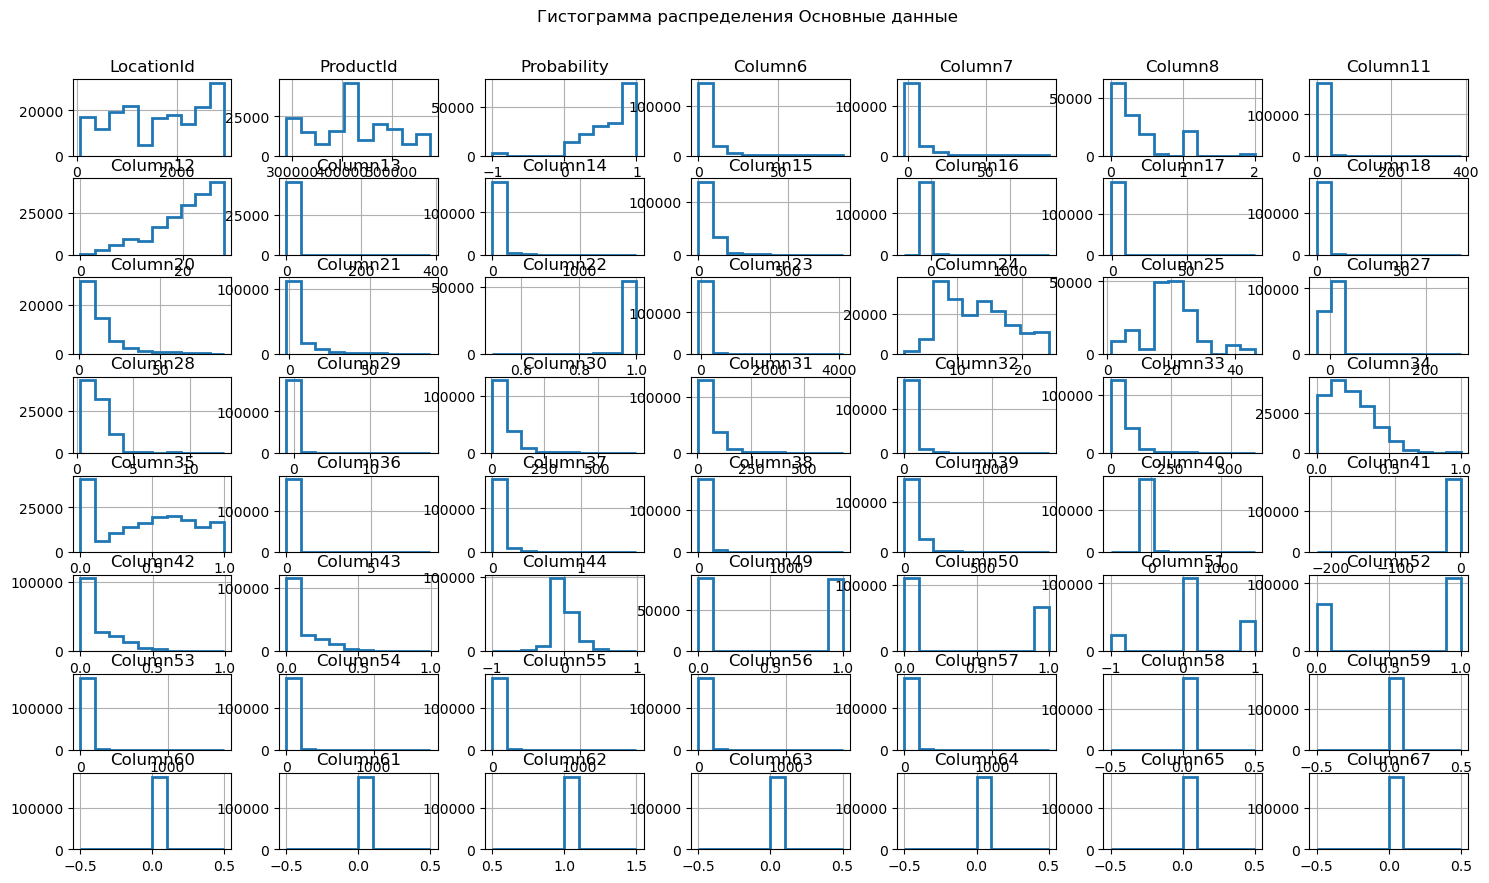

,LocationId,ProductId,Probability,Column6,Column7,Column8,Column11,Column12,Column13,Column14,...,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column67
count,176618.000000,176618.000000,176305.000000,176618.000000,176618.000000,141486.000000,176618.000000,176618.000000,45863.000000,176617.000000,...,176617.000000,176617.0,176617.0,176617.0,176617.0,176617.0,176617.0,176617.0,176617.0,176617.0
mean,1654.755591,423817.321847,0.650315,5.281319,4.383947,0.341128,4.305674,20.391636,4.425015,60.364611,...,60.364611,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
std,893.324832,79493.656830,0.348815,8.960510,8.961102,0.370759,4.236874,6.158378,5.613347,48.695090,...,48.695090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,63.000000,288312.000000,-1.000000,0.000000,-2.000000,0.000000,0.035714,0.000000,0.000000,0.180000,...,0.180000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25%,872.000000,361374.000000,0.441461,1.000000,0.000000,0.076923,2.214286,17.000000,2.071429,25.990000,...,25.990000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
50%,1719.000000,425916.000000,0.724501,3.000000,2.000000,0.200000,3.464286,22.000000,3.200000,49.990002,...,49.990002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
75%,2553.000000,485473.000000,0.959633,6.000000,5.000000,0.500000,5.178571,25.000000,5.090909,74.989998,...,74.989998,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
max,2950.000000,576760.000000,1.000000,90.000000,90.000000,2.000000,386.107147,28.000000,386.190491,1650.000000,...,1650.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288527,2023-06-28 14:57:07,0.416474,False,86.0,85.0,0.011628,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
1,63,288606,2023-06-01 15:32:31,0.687710,False,8.0,7.0,0.125000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
2,63,288606,2023-06-03 12:55:49,0.810382,False,10.0,9.0,0.100000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
3,63,288606,2023-06-07 14:57:38,0.312500,False,4.0,3.0,0.250000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
4,63,288606,2023-06-09 14:56:35,0.605429,False,6.0,5.0,0.166667,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0


In [21]:
research(df, 'Основные данные', figsize=(18, 10), silent=False)

# Создадим новые признаки

In [22]:
# календаот праздников РФ
rus_holidays = holidays.Russia()

# определение является ли день праздником или выходным
def is_holiday_or_weekend(date):
    return date in rus_holidays or date.weekday() >= 5  # выходные (суббота и воскресенье) имеют код 5 и 6

# даты в datetime
df['ValidationDateTime'] = pd.to_datetime(df['ValidationDateTime'])

# столбец "Holidays" с признаком праздника
df['Holidays'] = df['ValidationDateTime'].apply(is_holiday_or_weekend)
df['Holidays'] = df['Holidays'].astype(int)

In [23]:
# добавим новые признаки - час, день недели
df['ValidationDateTime'] = pd.to_datetime(df['ValidationDateTime'])
df['Hour'] = df['ValidationDateTime'].dt.hour
df['Weekday'] = df['ValidationDateTime'].dt.weekday
df['ValidationDateTime'] = df['ValidationDateTime'].dt.date

In [24]:
df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column61,Column62,Column63,Column64,Column65,Column66,Column67,Holidays,Hour,Weekday
0,63,288527,2023-06-28,0.416474,False,86.0,85.0,0.011628,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,2
1,63,288606,2023-06-01,0.687710,False,8.0,7.0,0.125000,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,3
2,63,288606,2023-06-03,0.810382,False,10.0,9.0,0.100000,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,1,12,5
3,63,288606,2023-06-07,0.312500,False,4.0,3.0,0.250000,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,2
4,63,288606,2023-06-09,0.605429,False,6.0,5.0,0.166667,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176613,2950,576631,2023-07-12,0.542776,True,1.0,0.0,1.000000,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,2
176614,2950,576631,2023-07-15,0.497054,True,4.0,4.0,0.000000,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,1,15,5
176615,2950,576631,2023-07-26,0.930926,None,1.0,0.0,1.000000,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,2
176616,2950,576631,2023-07-28,0.704421,None,3.0,2.0,0.333333,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,4


In [25]:
# функция для подсчета пропусков в столбцах в процентах
def lost(data):
    if data.isna().sum().sum()>0:
        display(
            (round(data.isna().mean()*100,3))
            .to_frame()
            .rename(columns = {0:'Пропуски'})
            .query('Пропуски > 0')
            .sort_values(by = 'Пропуски', ascending = False)
            .style.background_gradient('coolwarm')
        )
    else:
        print('Пропусков нет')

In [26]:
lost(df)

,Пропуски
Column9,100.000000
Column10,100.000000
Column66,100.000000
Column26,100.000000
Column13,74.033000
Column20,68.696000
Column22,68.696000
Column28,49.441000
IsCorrect,23.084000
Column8,19.892000


In [27]:
# заменим True на 1 и False на 0 
df['IsCorrect'] = df['IsCorrect'].replace({True: 1, False: 0})
df['Column19'] = df['Column19'].replace({True: 1, False: 0})

In [28]:
df

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column61,Column62,Column63,Column64,Column65,Column66,Column67,Holidays,Hour,Weekday
0,63,288527,2023-06-28,0.416474,0.0,86.0,85.0,0.011628,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,2
1,63,288606,2023-06-01,0.687710,0.0,8.0,7.0,0.125000,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,3
2,63,288606,2023-06-03,0.810382,0.0,10.0,9.0,0.100000,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,1,12,5
3,63,288606,2023-06-07,0.312500,0.0,4.0,3.0,0.250000,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,2
4,63,288606,2023-06-09,0.605429,0.0,6.0,5.0,0.166667,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176613,2950,576631,2023-07-12,0.542776,1.0,1.0,0.0,1.000000,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,2
176614,2950,576631,2023-07-15,0.497054,1.0,4.0,4.0,0.000000,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,1,15,5
176615,2950,576631,2023-07-26,0.930926,NaN,1.0,0.0,1.000000,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,2
176616,2950,576631,2023-07-28,0.704421,NaN,3.0,2.0,0.333333,None,None,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,4


In [29]:
df = df.drop(['Probability'], axis=1)

In [30]:
train_df = df[~df['IsCorrect'].isna()]
train_df

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column9,Column10,Column11,...,Column61,Column62,Column63,Column64,Column65,Column66,Column67,Holidays,Hour,Weekday
0,63,288527,2023-06-28,0.0,86.0,85.0,0.011628,None,None,0.142857,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,2
1,63,288606,2023-06-01,0.0,8.0,7.0,0.125000,None,None,3.714286,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,3
2,63,288606,2023-06-03,0.0,10.0,9.0,0.100000,None,None,3.214286,...,0.0,1.0,0.0,0.0,0.0,None,0.0,1,12,5
3,63,288606,2023-06-07,0.0,4.0,3.0,0.250000,None,None,3.178571,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,2
4,63,288606,2023-06-09,0.0,6.0,5.0,0.166667,None,None,3.035714,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176609,2950,574768,2023-07-19,1.0,0.0,-1.0,NaN,None,None,2.214286,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,2
176611,2950,575450,2023-06-20,0.0,1.0,0.0,1.000000,None,None,3.000000,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,1
176612,2950,576459,2023-07-02,0.0,41.0,40.0,0.024390,None,None,0.964286,...,0.0,1.0,0.0,0.0,0.0,None,0.0,1,15,6
176613,2950,576631,2023-07-12,1.0,1.0,0.0,1.000000,None,None,4.285714,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,2


In [31]:
test_df = df[df['IsCorrect'].isna()]
test_df

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column9,Column10,Column11,...,Column61,Column62,Column63,Column64,Column65,Column66,Column67,Holidays,Hour,Weekday
11,63,288606,2023-07-25,NaN,14.0,13.0,0.071429,None,None,3.071429,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,1
12,63,288606,2023-08-03,NaN,2.0,1.0,0.500000,None,None,1.392857,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,3
14,63,288783,2023-07-24,NaN,4.0,4.0,0.000000,None,None,2.000000,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,0
15,63,288783,2023-08-03,NaN,0.0,-1.0,NaN,None,None,1.964286,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,3
24,63,289136,2023-07-24,NaN,6.0,6.0,0.000000,None,None,1.357143,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176604,2950,572875,2023-07-26,NaN,19.0,18.0,0.052632,None,None,3.785714,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,2
176610,2950,574768,2023-07-31,NaN,10.0,9.0,0.100000,None,None,1.321429,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,0
176615,2950,576631,2023-07-26,NaN,1.0,0.0,1.000000,None,None,3.571429,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,2
176616,2950,576631,2023-07-28,NaN,3.0,2.0,0.333333,None,None,3.607143,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,4


In [32]:
# заменим пропуски медианой
# filtered_df = filtered_df.fillna(filtered_df.median())

           proportion
IsCorrect            
0.0          0.770403
1.0          0.229597


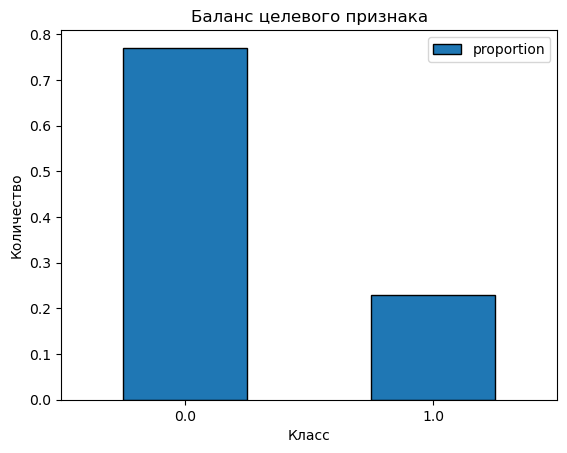

In [33]:
# оценим баланс целевого признака
class_frequency = df['IsCorrect'].value_counts(normalize=True).to_frame()
print(class_frequency)

ax = class_frequency.plot(kind='bar', rot=0, edgecolor='black', linewidth=1)
ax.set_xlabel('Класс')
ax.set_ylabel('Количество')
ax.set_title('Баланс целевого признака')
plt.show()

In [34]:
#filtered_df['ValidationDateTime'] = pd.to_datetime(filtered_df['ValidationDateTime'])

In [35]:
train_df = df[~df['IsCorrect'].isna()]
# заменим пропуски 0
train_df.fillna(0, inplace=True)
train_df

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column9,Column10,Column11,...,Column61,Column62,Column63,Column64,Column65,Column66,Column67,Holidays,Hour,Weekday
0,63,288527,2023-06-28,0.0,86.0,85.0,0.011628,0,0,0.142857,...,0.0,1.0,0.0,0.0,0.0,0,0.0,0,14,2
1,63,288606,2023-06-01,0.0,8.0,7.0,0.125000,0,0,3.714286,...,0.0,1.0,0.0,0.0,0.0,0,0.0,0,15,3
2,63,288606,2023-06-03,0.0,10.0,9.0,0.100000,0,0,3.214286,...,0.0,1.0,0.0,0.0,0.0,0,0.0,1,12,5
3,63,288606,2023-06-07,0.0,4.0,3.0,0.250000,0,0,3.178571,...,0.0,1.0,0.0,0.0,0.0,0,0.0,0,14,2
4,63,288606,2023-06-09,0.0,6.0,5.0,0.166667,0,0,3.035714,...,0.0,1.0,0.0,0.0,0.0,0,0.0,0,14,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176609,2950,574768,2023-07-19,1.0,0.0,-1.0,0.000000,0,0,2.214286,...,0.0,1.0,0.0,0.0,0.0,0,0.0,0,15,2
176611,2950,575450,2023-06-20,0.0,1.0,0.0,1.000000,0,0,3.000000,...,0.0,1.0,0.0,0.0,0.0,0,0.0,0,15,1
176612,2950,576459,2023-07-02,0.0,41.0,40.0,0.024390,0,0,0.964286,...,0.0,1.0,0.0,0.0,0.0,0,0.0,1,15,6
176613,2950,576631,2023-07-12,1.0,1.0,0.0,1.000000,0,0,4.285714,...,0.0,1.0,0.0,0.0,0.0,0,0.0,0,15,2


In [36]:
test_df = df[df['IsCorrect'].isna()]
test_df

,LocationId,ProductId,ValidationDateTime,IsCorrect,Column6,Column7,Column8,Column9,Column10,Column11,...,Column61,Column62,Column63,Column64,Column65,Column66,Column67,Holidays,Hour,Weekday
11,63,288606,2023-07-25,NaN,14.0,13.0,0.071429,None,None,3.071429,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,1
12,63,288606,2023-08-03,NaN,2.0,1.0,0.500000,None,None,1.392857,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,3
14,63,288783,2023-07-24,NaN,4.0,4.0,0.000000,None,None,2.000000,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,0
15,63,288783,2023-08-03,NaN,0.0,-1.0,NaN,None,None,1.964286,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,3
24,63,289136,2023-07-24,NaN,6.0,6.0,0.000000,None,None,1.357143,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176604,2950,572875,2023-07-26,NaN,19.0,18.0,0.052632,None,None,3.785714,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,2
176610,2950,574768,2023-07-31,NaN,10.0,9.0,0.100000,None,None,1.321429,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,0
176615,2950,576631,2023-07-26,NaN,1.0,0.0,1.000000,None,None,3.571429,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,2
176616,2950,576631,2023-07-28,NaN,3.0,2.0,0.333333,None,None,3.607143,...,0.0,1.0,0.0,0.0,0.0,None,0.0,0,15,4


In [37]:
# признаки
features = train_df.drop(['IsCorrect'], axis=1)             # признаки
target = train_df['IsCorrect']                              # целевой признак

# разделим на тренировочную - 80% и валид - 20% выборки
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.2, random_state=RANDOM_STATE)
 

In [38]:
print('\033[1m'+ 'Обучающая выборка'+'\033[0m')
print ('Признаки:',X_train.shape, '\n', 'Целевой признак:', y_train.shape, sep='')
print('='*30)
print('\033[1m'+ 'Тестовая выборка'+'\033[0m')
print ('Признаки:',X_valid.shape, '\n', 'Целевой признак:', y_valid.shape, sep='')

Обучающая выборка
Признаки:(108677, 67)
Целевой признак:(108677,)
Тестовая выборка
Признаки:(27170, 67)
Целевой признак:(27170,)


# Модель "CatBoostClassifier"

In [39]:
columns = X_train.columns
columns

Index(['LocationId', 'ProductId', 'ValidationDateTime', 'Column6', 'Column7',
       'Column8', 'Column9', 'Column10', 'Column11', 'Column12', 'Column13',
       'Column14', 'Column15', 'Column16', 'Column17', 'Column18', 'Column19',
       'Column20', 'Column21', 'Column22', 'Column23', 'Column24', 'Column25',
       'Column26', 'Column27', 'Column28', 'Column29', 'Column30', 'Column31',
       'Column32', 'Column33', 'Column34', 'Column35', 'Column36', 'Column37',
       'Column38', 'Column39', 'Column40', 'Column41', 'Column42', 'Column43',
       'Column44', 'Column45', 'Column46', 'Column47', 'Column49', 'Column50',
       'Column51', 'Column52', 'Column53', 'Column54', 'Column55', 'Column56',
       'Column57', 'Column58', 'Column59', 'Column60', 'Column61', 'Column62',
       'Column63', 'Column64', 'Column65', 'Column66', 'Column67', 'Holidays',
       'Hour', 'Weekday'],
      dtype='object')

In [40]:
columns = X_valid.columns
columns

Index(['LocationId', 'ProductId', 'ValidationDateTime', 'Column6', 'Column7',
       'Column8', 'Column9', 'Column10', 'Column11', 'Column12', 'Column13',
       'Column14', 'Column15', 'Column16', 'Column17', 'Column18', 'Column19',
       'Column20', 'Column21', 'Column22', 'Column23', 'Column24', 'Column25',
       'Column26', 'Column27', 'Column28', 'Column29', 'Column30', 'Column31',
       'Column32', 'Column33', 'Column34', 'Column35', 'Column36', 'Column37',
       'Column38', 'Column39', 'Column40', 'Column41', 'Column42', 'Column43',
       'Column44', 'Column45', 'Column46', 'Column47', 'Column49', 'Column50',
       'Column51', 'Column52', 'Column53', 'Column54', 'Column55', 'Column56',
       'Column57', 'Column58', 'Column59', 'Column60', 'Column61', 'Column62',
       'Column63', 'Column64', 'Column65', 'Column66', 'Column67', 'Holidays',
       'Hour', 'Weekday'],
      dtype='object')

In [41]:
# кодируем признаки
cat = ['LocationId', 'ProductId', 'ValidationDateTime', 'Holidays', 'Hour', 'Weekday']
num = ['Column6', 'Column7',
       'Column8', 'Column9', 'Column10', 'Column11', 'Column12', 'Column13',
       'Column14', 'Column15', 'Column16', 'Column17', 'Column18', 'Column19',
       'Column20', 'Column21', 'Column22', 'Column23', 'Column24', 'Column25',
       'Column26', 'Column27', 'Column28', 'Column29', 'Column30', 'Column31',
       'Column32', 'Column33', 'Column34', 'Column35', 'Column36', 'Column37',
       'Column38', 'Column39', 'Column40', 'Column41', 'Column42', 'Column43',
       'Column44', 'Column45', 'Column46', 'Column47', 'Column49', 'Column50',
       'Column51', 'Column52', 'Column53', 'Column54', 'Column55', 'Column56',
       'Column57', 'Column58', 'Column59', 'Column60', 'Column61', 'Column62',
       'Column63', 'Column64', 'Column65', 'Column66', 'Column67']
enc = TargetEncoder(target_type='continuous', smooth='auto')
X_tr_enc = pd.DataFrame(enc.fit_transform(X_train[cat], y=y_train),
 columns=enc.get_feature_names_out(X_train[cat].columns), index=X_train[cat].index)
X_vl_enc = pd.DataFrame(enc.transform(X_valid[cat]),
 columns=enc.get_feature_names_out(X_train[cat].columns), index=X_valid[cat].index)
scaler = StandardScaler()
X_tr_sc = pd.DataFrame(scaler.fit_transform(X_train[num]), columns=scaler.get_feature_names_out(X_train[num].columns), 
    index = X_train[num].index)
X_vl_sc = pd.DataFrame(scaler.fit_transform(X_valid[num]), columns=scaler.get_feature_names_out(X_valid[num].columns), 
    index = X_valid[num].index)
X_train = pd.concat([X_tr_enc, X_tr_sc], axis=1)
X_valid = pd.concat([X_vl_enc, X_vl_sc], axis=1)

In [42]:
# категориальные и числовые признаки
categorical_columns = list(X_train.select_dtypes(include='object').columns)
num_features = list(X_train.select_dtypes(exclude='object').columns)

# модель CatBoostClassifier
model_cb = CatBoostClassifier(
    random_state=RANDOM_STATE,
    loss_function='Logloss',
    verbose=False,
    class_weights=[0.229597, 0.770403],
    cat_features=categorical_columns
)

# параметры для подбора
parameters_cb = {
    'learning_rate': [0.1, 0.5, 0.8],
    'depth': [6, 8, 10],
    'iterations': [30, 50, 100]
}

# cv для подбора параметров
cb = GridSearchCV(
    estimator=model_cb,
    param_grid=parameters_cb,
    cv=2,
    scoring='roc_auc',
    n_jobs=-1
)

# обучение 
cb.fit(X_train, y_train)

best_cb_model = cb.best_estimator_

# прогноз на тестовой выборке
y_pred_valid_cb = best_cb_model.predict(X_valid)

# Расчет метрик
roc_auc_valid = roc_auc_score(y_valid, y_pred_valid_cb)
accuracy_valid = accuracy_score(y_valid, y_pred_valid_cb)
recall_valid = recall_score(y_valid, y_pred_valid_cb)
precision_valid = precision_score(y_valid, y_pred_valid_cb)
f1_valid = f1_score(y_valid, y_pred_valid_cb)

# Вывод результатов
print('\033[1m' + 'Модель "CatBoostClassifier"' + '\033[0m')
print('=' * 40)
print('\033[1m' + 'Лучший ROC-AUC на тренировочных данных:' + '\033[0m', cb.best_score_)
print('\033[1m' + 'ROC-AUC на валидных данных:' + '\033[0m', roc_auc_valid)
print('\033[1m' + 'Accuracy на валидных данных:' + '\033[0m', accuracy_valid)
print('\033[1m' + 'Recall на валидных данных:' + '\033[0m', recall_valid)
print('\033[1m' + 'Precision на валидных данных:' + '\033[0m', precision_valid)
print('\033[1m' + 'F1-мера на валидных данных:' + '\033[0m', f1_valid)
print('=' * 40)
print("Лучшие параметры:", cb.best_params_)
print('=' * 40)

Модель "CatBoostClassifier"
Лучший ROC-AUC на тренировочных данных: 0.8962569670009152
ROC-AUC на валидных данных: 0.8179091457617719
Accuracy на валидных данных: 0.8322782480677218
Recall на валидных данных: 0.7914120295915085
Precision на валидных данных: 0.6015157071262682
F1-мера на валидных данных: 0.6835196888672824
Лучшие параметры: {'depth': 8, 'iterations': 100, 'learning_rate': 0.1}


# Метрики на валидной выборке

In [43]:
# результат
index_result =['Лучший ROC-AUC на тренировочных данных',
               'ROC-AUC на валидных данных',
               'Accuracy на валидных данных',
               'Recall на валидных данных',
               'Precision на валидных данных',
               'F1-мера на валидных данных']

data_result = {
    'CatBoostClassifier': [
        cb.best_score_,
        roc_auc_valid,
        accuracy_valid,
        recall_valid,
        precision_valid,
        f1_valid
    ]
}
result = pd.DataFrame(data_result, index=index_result)
result.index.name = 'Метрика'
result

,CatBoostClassifier
Метрика,
Лучший ROC-AUC на тренировочных данных,0.896257
ROC-AUC на валидных данных,0.817909
Accuracy на валидных данных,0.832278
Recall на валидных данных,0.791412
Precision на валидных данных,0.601516
F1-мера на валидных данных,0.683520


# Построим кривую AUC-ROC для лучшей модели

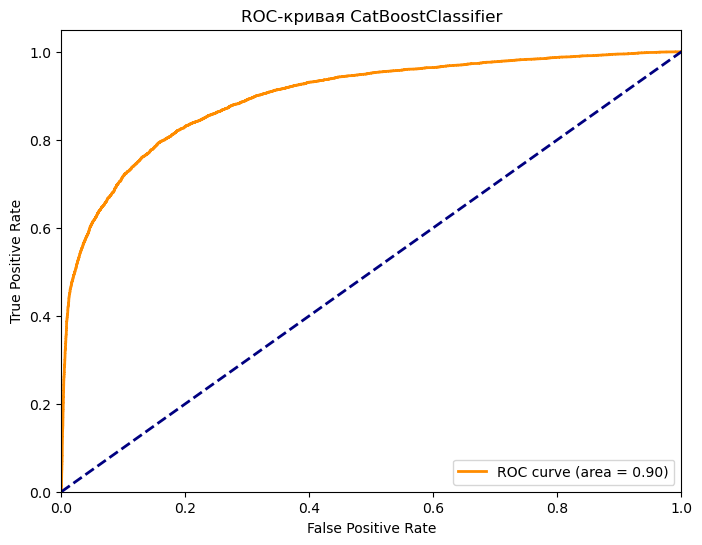

In [44]:
# предсказанных вероятностей класса 1
y_pred_proba = best_cb_model.predict_proba(X_valid)[:, 1]

# передаем на вход значения целевого признака и вероятности положительного класса
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

# вычисление значения AUC
roc_auc = auc(fpr, tpr)

# строим ROC-кривую
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая CatBoostClassifier')
plt.legend(loc="lower right")
plt.show()

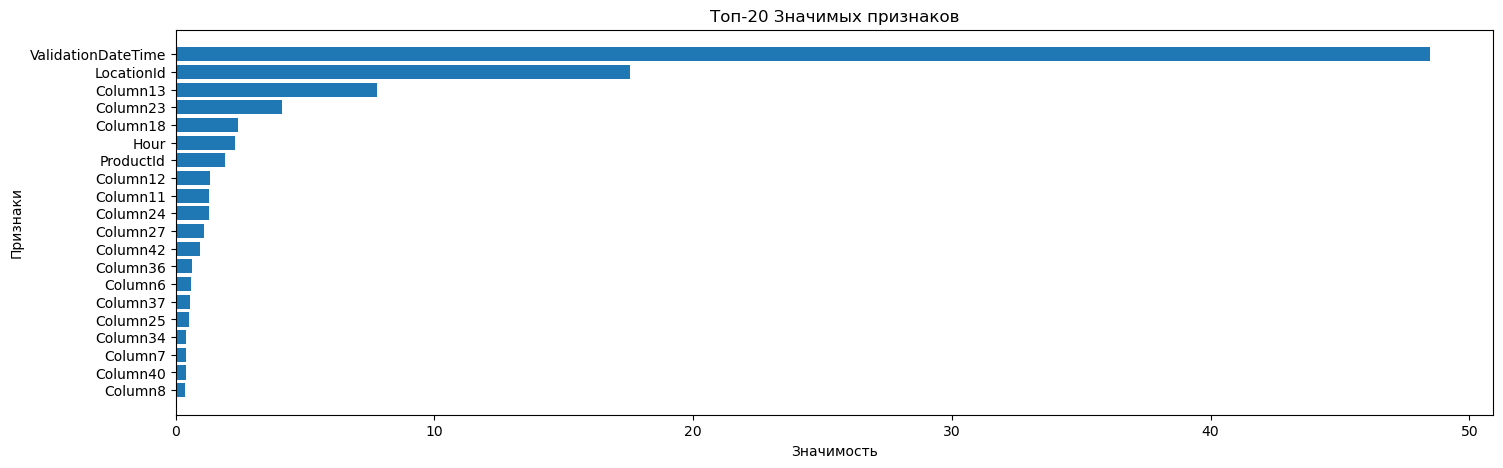

In [45]:
# получим признаки
importance = best_cb_model.feature_importances_
feature_names = X_train.columns

# сортируем признаки по значимости
sorting_indices = np.argsort(importance)[::-1] 
top_n = 20  # количество признаков для вывода

sorting_importance = importance[sorting_indices][:top_n]
sorting_feature_names = feature_names[sorting_indices][:top_n]

# визуализируем
plt.figure(figsize=(17, 5))
plt.barh(range(len(sorting_importance)), sorting_importance)
plt.yticks(range(len(sorting_importance)), sorting_feature_names)
plt.xlabel('Значимость')
plt.ylabel('Признаки')
plt.title('Топ-20 Значимых признаков')
plt.gca().invert_yaxis()
plt.show()

# Получение вероятностей и выгрузка для test_df

In [52]:
# признаки для выгрузки вероятностей test_df
X_train = train_df.drop(['IsCorrect'], axis=1)    
X_valid = test_df.drop(['IsCorrect'], axis=1)    
y_train = train_df['IsCorrect']  
y_valid = test_df['IsCorrect'] 

In [53]:
# кодируем признаки
cat = ['LocationId', 'ProductId', 'ValidationDateTime', 'Holidays', 'Hour', 'Weekday']
num = ['Column6', 'Column7',
       'Column8', 'Column9', 'Column10', 'Column11', 'Column12', 'Column13',
       'Column14', 'Column15', 'Column16', 'Column17', 'Column18', 'Column19',
       'Column20', 'Column21', 'Column22', 'Column23', 'Column24', 'Column25',
       'Column26', 'Column27', 'Column28', 'Column29', 'Column30', 'Column31',
       'Column32', 'Column33', 'Column34', 'Column35', 'Column36', 'Column37',
       'Column38', 'Column39', 'Column40', 'Column41', 'Column42', 'Column43',
       'Column44', 'Column45', 'Column46', 'Column47', 'Column49', 'Column50',
       'Column51', 'Column52', 'Column53', 'Column54', 'Column55', 'Column56',
       'Column57', 'Column58', 'Column59', 'Column60', 'Column61', 'Column62',
       'Column63', 'Column64', 'Column65', 'Column66', 'Column67']
enc = TargetEncoder(target_type='continuous', smooth='auto')
X_tr_enc = pd.DataFrame(enc.fit_transform(X_train[cat], y=y_train),
 columns=enc.get_feature_names_out(X_train[cat].columns), index=X_train[cat].index)
X_vl_enc = pd.DataFrame(enc.transform(X_valid[cat]),
 columns=enc.get_feature_names_out(X_train[cat].columns), index=X_valid[cat].index)
scaler = StandardScaler()
X_tr_sc = pd.DataFrame(scaler.fit_transform(X_train[num]), columns=scaler.get_feature_names_out(X_train[num].columns), 
    index = X_train[num].index)
X_vl_sc = pd.DataFrame(scaler.fit_transform(X_valid[num]), columns=scaler.get_feature_names_out(X_valid[num].columns), 
    index = X_valid[num].index)
X_train = pd.concat([X_tr_enc, X_tr_sc], axis=1)
X_valid = pd.concat([X_vl_enc, X_vl_sc], axis=1)

In [54]:
# категориальные и числовые признаки
categorical_columns = list(X_train.select_dtypes(include='object').columns)
num_features = list(X_train.select_dtypes(exclude='object').columns)

# модель CatBoostClassifier
model_cb = CatBoostClassifier(
    random_state=RANDOM_STATE,
    loss_function='Logloss',
    verbose=False,
    class_weights=[0.229597, 0.770403],
    cat_features=categorical_columns
)

# параметры для подбора
parameters_cb = {
    'learning_rate': [0.1, 0.5, 0.8],
    'depth': [6, 8, 10],
    'iterations': [30, 50, 100]
}

# cv для подбора параметров
cb = GridSearchCV(
    estimator=model_cb,
    param_grid=parameters_cb,
    cv=2,
    scoring='roc_auc',
    n_jobs=-1
)

# обучение 
cb.fit(X_train, y_train)

best_cb_model = cb.best_estimator_

# прогноз на тестовой выборке
y_pred_valid_cb = best_cb_model.predict(X_valid)

In [56]:
predicted_probabilities = best_cb_model.predict_proba(X_valid)
# вероятности для класса 1 
calculated_probabilities = predicted_probabilities[:, 1]
calculated_probabilities

array([0.86691171, 0.73946515, 0.748948  , ..., 0.64671619, 0.61536313,
       0.69143411])

In [57]:
test_df['CalculatedProbability'] = calculated_probabilities
checkpoint = test_df[['LocationId','ProductId','ValidationDateTime','CalculatedProbability']]

In [58]:
checkpoint = checkpoint.sort_values(by='ValidationDateTime')
checkpoint

,LocationId,ProductId,ValidationDateTime,CalculatedProbability
157534,2763,310892,2023-07-22,0.911128
100600,1927,496498,2023-07-22,0.436667
163062,2811,413140,2023-07-22,0.172534
11066,263,563236,2023-07-22,0.613170
121905,2354,309093,2023-07-22,0.627507
...,...,...,...,...
160975,2799,413141,2023-08-04,0.278443
127827,2489,469692,2023-08-04,0.549425
87671,1717,425652,2023-08-04,0.804171
161017,2799,420893,2023-08-04,0.172722


In [59]:
checkpoint.to_csv('checkpoint_3.csv', index=False, sep=';')

# Вывод 

1. Загружены и изученны данные о товарах
2. Данные представлены в зашифрованном виде
3. Проведен первичный исследовательский анализ
- обнаружены пропуски и отсутвующие значения
- природа пропусков не ясна, принято решение заполнить нулевыми значениями
4. Дополнительно сформированы признаки: 
- 'Holidays' - является ли день праздничным или выходным
- 'Weekday' - номер дня недели
- 'Hour' - час, когда были полученны данные
5. Признаки разделны на категориальные и численные, закодированы TargetEncoder
6. Использованна моедель **CatBoostClassifier**
7. Параметры моедли подобранны с помощью **GridSearchCV**
8. Лучшая модель: параметры: {'depth': 8, 'iterations': 100, 'learning_rate': 0.1}
9. В топ-20 значимых признаков вошел вновь сформированный 'Hour' - час, когда были полученны данные (6 место)

**РЕЗУЛЬТАТ** 
На чек-поинте №2
**ROC-AUC = 0,722**